### Проект по исследованию и предсказанию цен на новостройки на основе базы данных с ЦИАН

### Кодирование и нормализация признаков, обучение моделей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import os
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [2]:
# Изменить текущую директорию на главную
os.chdir('..')

In [3]:
python_path = os.path.join('/home/admin1/anaconda3/lib/python3.7/site-packages')
sys.path.append(python_path)
os.environ["PYTHONPATH"] = python_path

In [4]:
from src.set_params import set_params
from src.preprocessing import preprocessing, load_data, feature_encoding
from src.preprocessing import feature_encoding, all_features_encoding
from src.preprocessing import add_price_of_distance, add_price_of_inflation
from src.training import compare_models, check_model_on_valid, evaluate

### 1. Загрузка данных
---

In [5]:
params_path = 'params.yaml'
params = set_params(params_path)

In [6]:
data_all = load_data(params)
data_train, data_valid = train_test_split(data_all, test_size=0.25, shuffle=False)

X_train, y_train = preprocessing(data_train, params)
X_valid, y_valid = preprocessing(data_valid, params)

Для надежности будем использовать кросс-валидацию при оценивании результатов.

Данные зависят от даты обновления, но не зависят от предыдущих значений. Поэтому кросс-валидация на нескольких подвыборках не должна приводить к утечке данных из тестового в тренировочный набор.

Выделим поднабор для конечной валидации, а остальные данные будем использовать для тренировки моделей

---
### 2. Кодирование признаков и нормализация

In [7]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)

Категориальные признаки будет кодировать через one-hot кодирование, а числовые признаки преобразуе с помощью стандартного распределния

In [8]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20386 entries, 11423 to 9741
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Объект продажи        20386 non-null  object 
 1   Общая площадь         20386 non-null  float64
 2   Этаж                  20386 non-null  int64  
 3   Этажей в доме         20386 non-null  int64  
 4   Парковка              20386 non-null  object 
 5   Количество комнат     20386 non-null  float64
 6   Тип дома              20386 non-null  object 
 7   Высота потолков       20386 non-null  float64
 8   Вид из окон           20386 non-null  int64  
 9   Расстояние до метро   20386 non-null  float64
 10  Адрес                 20386 non-null  object 
 11  Дата обновления       20386 non-null  object 
 12  Высота неизвестнно    20386 non-null  uint8  
 13  Высота менее 2.5-3 м  20386 non-null  uint8  
 14  Высота более 3 м      20386 non-null  uint8  
 15  Широта          

In [9]:
X_train_, X_test_ = add_price_of_distance(X_train_, y_train_, X_test_, p0=params.fit_distance_params)

In [10]:
X_train_, X_test_ = add_price_of_inflation(X_train_, y_train_, X_test_, p0=params.fit_inflation_params)

In [11]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20386 entries, 11423 to 9741
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Объект продажи           20386 non-null  object 
 1   Общая площадь            20386 non-null  float64
 2   Этаж                     20386 non-null  int64  
 3   Этажей в доме            20386 non-null  int64  
 4   Парковка                 20386 non-null  object 
 5   Количество комнат        20386 non-null  float64
 6   Тип дома                 20386 non-null  object 
 7   Высота потолков          20386 non-null  float64
 8   Вид из окон              20386 non-null  int64  
 9   Расстояние до метро      20386 non-null  float64
 10  Адрес                    20386 non-null  object 
 11  Дата обновления          20386 non-null  object 
 12  Высота неизвестнно       20386 non-null  uint8  
 13  Высота менее 2.5-3 м     20386 non-null  uint8  
 14  Высота более 3 м   

In [12]:
X_train_.select_dtypes(include=np.number).head()

,Общая площадь,Этаж,Этажей в доме,Количество комнат,Высота потолков,Вид из окон,Расстояние до метро,Высота неизвестнно,Высота менее 2.5-3 м,Высота более 3 м,Широта,Долгота,Расстояние от центра,Дней,Стоимость от расстояния,Стоимость с инфляцией
11423,42.07,21,30,1.0,0.00,0,15.0,1,0,0,55.869357,37.488795,0.172642,277,1.277901e+07,9.346017e+06
5986,88.51,16,23,3.0,0.00,0,20.0,1,0,0,55.870168,37.643606,0.121247,343,1.264675e+07,1.306706e+07
16216,101.90,14,20,3.0,0.00,0,55.0,1,0,0,55.826742,37.435495,0.194921,313,1.178557e+07,1.122066e+07
21158,73.10,2,16,2.0,2.89,0,120.0,0,1,0,55.550157,37.387379,0.304805,313,1.045108e+07,1.122066e+07
23475,98.60,8,22,3.0,0.00,0,240.0,1,0,0,55.550157,37.387379,0.304805,282,8.684012e+06,9.586348e+06


In [13]:
X_train_.select_dtypes(exclude=np.number).head()

,Объект продажи,Парковка,Тип дома,Адрес,Дата обновления
11423,Новостройка,Подземная,Монолитный,"Москва,САО,район Ховрино,улица Дыбенко",10/5/2019 5:55:04 AM
5986,Новостройка,Подземная,Монолитный,"Москва,СВАО,район Свиблово,Сельскохозяйственна...",12.10.2019 18:47:33
16216,Новостройка,Подземная,Монолитный,"Москва,СЗАО,район Покровское-Стрешнево,улица Ц...",11.10.2019 5:35:05
21158,Новостройка,Подземная,Монолитный,"Москва,НАО (Новомосковский),Сосенское поселени...",11.10.2019 2:15:05
23475,Новостройка,Подземная,Монолитный,"Москва,НАО (Новомосковский),Родниковая улица",10.10.2019 23:40:05


In [17]:
cat_features = ['Парковка', 'Тип дома']
num_features = X_train.select_dtypes(include=np.number).drop(['Расстояние до метро', 'Дней'], axis=1).columns

X_train_, X_test_, X_valid_ = all_features_encoding(X_train_, X_test_, X_valid, cat_features, num_features)

---

Временно **не используем признаки Стоимость от расстояния, Стоимость с инфляцией**. Требуется изменить функцию для кросс-валидации, чтобы только на тренировочном наборе вычислялись параметры аппроксимирующих функций, а потом заполнялись данные в тренировочном и тестовом наборе.

Иначе - функции будут источником утечки данных

Аналог fit и fit_transform

In [19]:
X_train_.head(3)

,Общая площадь,Этаж,Этажей в доме,Количество комнат,Высота потолков,Вид из окон,Высота неизвестнно,Высота менее 2.5-3 м,Высота более 3 м,Широта,Долгота,Расстояние от центра,Наземная,Неизвестно,Подземная,Кирпичный,Монолитно-кирпичный,Монолитный,Панельный
11423,-0.912556,1.254174,1.083919,-1.27359,-0.961945,-0.371645,0.955093,-0.787315,-0.322822,0.429916,-0.101820,-0.133272,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5986,1.418880,0.628603,0.281034,1.29679,-0.961945,-0.371645,0.955093,-0.787315,-0.322822,0.431798,0.073689,-0.188030,0.0,0.0,1.0,0.0,0.0,1.0,0.0
16216,2.091100,0.378375,-0.063060,1.29679,-0.961945,-0.371645,0.955093,-0.787315,-0.322822,0.330987,-0.162246,-0.109536,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 3. Простое сравнение различных моделей

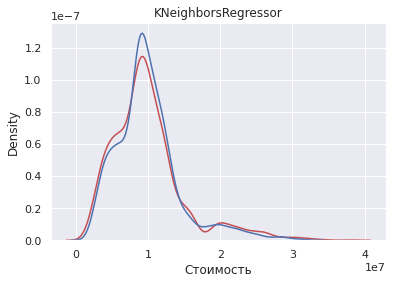

KNeighborsRegressor finished


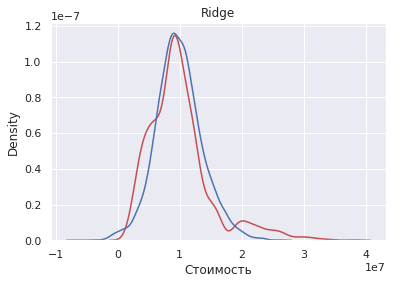

Ridge finished


/home/admin1/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 739742309544096.0, tolerance: 55248428601067.0
  positive)


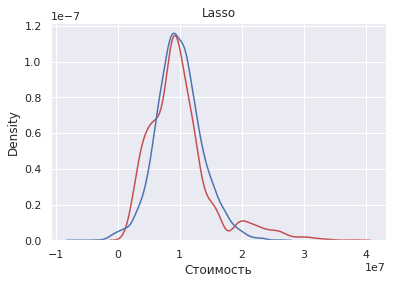

Lasso finished


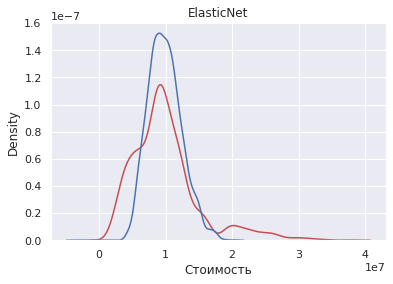

ElasticNet finished


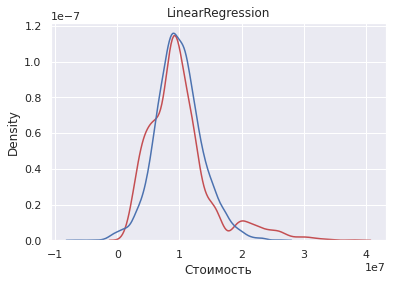

LinearRegression finished


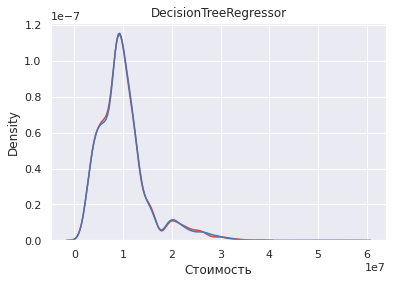

DecisionTreeRegressor finished


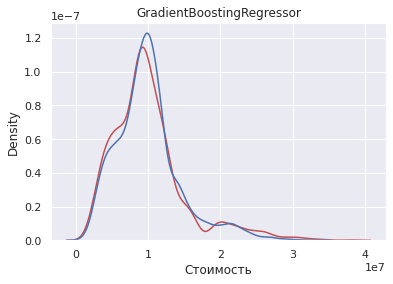

GradientBoostingRegressor finished


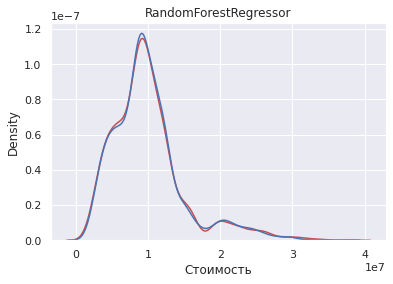

RandomForestRegressor finished


In [20]:
list_of_models = [
    KNeighborsRegressor, Ridge, Lasso, ElasticNet, LinearRegression, 
    DecisionTreeRegressor, GradientBoostingRegressor, RandomForestRegressor
]

df_scores = compare_models(X_train_, y_train_, X_test_, y_test_, 
                           models=list_of_models)

In [21]:
df_scores

,model,mae,mse,rmse,r2_square
0,KNeighborsRegressor,1.142106e+06,4.985724e+12,2.232873e+06,0.813320
1,Ridge,2.651623e+06,1.328651e+13,3.645066e+06,0.502514
2,Lasso,2.651720e+06,1.328656e+13,3.645074e+06,0.502512
3,ElasticNet,2.824808e+06,1.566278e+13,3.957623e+06,0.413539
4,LinearRegression,2.651749e+06,1.328726e+13,3.645169e+06,0.502486
5,DecisionTreeRegressor,6.317808e+05,2.460271e+12,1.568525e+06,0.907880
6,GradientBoostingRegressor,1.250268e+06,4.093250e+12,2.023178e+06,0.846737
7,RandomForestRegressor,5.422198e+05,1.520091e+12,1.232920e+06,0.943083


#### RandomForestRegressor

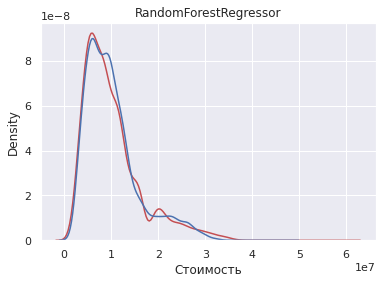

,mae,mse,rmse,r2_square
7,5.422198e+05,1.520091e+12,1.232920e+06,0.943083
0,1.245397e+06,5.376301e+12,2.318685e+06,0.861807


In [22]:
model = RandomForestRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_scores[df_scores.model == model.__name__][df_valid_scores.columns].append(df_valid_scores)

#### GradientBoostingRegressor

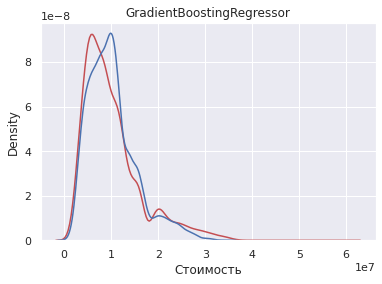

,mae,mse,rmse,r2_square
6,1.250268e+06,4.093250e+12,2.023178e+06,0.846737
0,1.692763e+06,7.670058e+12,2.769487e+06,0.802848


In [23]:
model = GradientBoostingRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_scores[df_scores.model == model.__name__][df_valid_scores.columns].append(df_valid_scores)

#### DecisionTreeRegressor

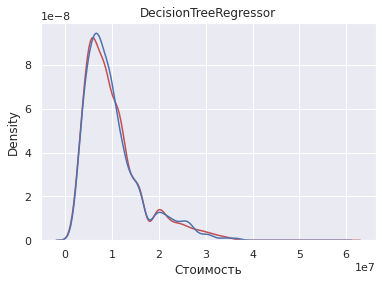

,mae,mse,rmse,r2_square
5,6.317808e+05,2.460271e+12,1.568525e+06,0.907880
0,1.603358e+06,9.286567e+12,3.047387e+06,0.761297


In [24]:
model = DecisionTreeRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_scores[df_scores.model == model.__name__][df_valid_scores.columns].append(df_valid_scores)

Большей обобщающей способностью обладает RandomForestRegressor, при этом у GradientBoostingRegressor меньше падает оценка предсказания. Возможно, GradientBoostingRegressor будет более устойчивой модельню со временем. 

### 4. Настройка лучших моделей

In [25]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor(n_jobs=-1)
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "min_samples_leaf": [2, 4, 8],
    "max_features": ["sqrt"],
    "min_samples_split" : [2, 6, 12],
    "max_depth": [5, 10, 15],
    }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1)
grid.fit(X_train_, y_train_)

y_pred = grid.best_estimator_.predict(X_test_)

print(
    metrics.mean_absolute_error(y_test_, y_pred), '\n', 
    metrics.mean_squared_error(y_test_, y_pred), '\n', 
    np.sqrt(metrics.mean_squared_error(y_test_, y_pred)), '\n',
    metrics.r2_score(y_test_, y_pred)
)

766239.8626362246 
 2066337672573.718 
 1437476.146784258 
 0.9226302335346424


### Проверка на валидационном наборе

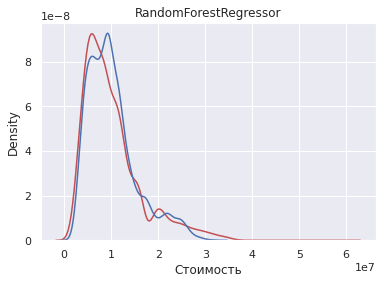

,mae,mse,rmse,r2_square,RandomForestRegressor
7,5.422198e+05,1.520091e+12,1.232920e+06,0.943083,test
0,1.462536e+06,6.359386e+12,2.521782e+06,0.836537,valid


In [31]:
y_pred = grid.best_estimator_.predict(X_valid_)
y_true = y_valid

df_valid_scores = pd.DataFrame(np.reshape(evaluate(y_true, y_pred), (1, -1)),
                           columns=['mae','mse','rmse','r2_square'])
model_name = 'RandomForestRegressor'
df_test_scores = df_scores[df_scores.model == model_name][df_valid_scores.columns]
df_test_scores = df_test_scores.append(df_valid_scores)
df_test_scores[model_name] = ['test', 'valid']

ax = sns.kdeplot(x=y_true, color='r', label='Actual value')
sns.kdeplot(x=y_pred, color='b', label='Predicted value', ax=ax)
ax.set(title=model_name)
plt.show()

df_test_scores

### 5. Дальнейшие улучшения 

In [28]:
# TODO Изменить функцию для кросс-валидации, чтобы добавлять стоимость от расстояния и инфляции
# TODO Попробовать вместо обычной валидацию на основе расширения набора (учёт времени)

# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=3)

In [29]:
# grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=tscv)
# grid.fit(x_train_choosen, y_train_choosen)

# y_pred = grid.best_estimator_.predict(x_test_choosen)

# print(
#     metrics.mean_absolute_error(y_test_choosen, y_pred), '\n', 
#     metrics.mean_squared_error(y_test_choosen, y_pred), '\n', 
#     np.sqrt(metrics.mean_squared_error(y_test_choosen, y_pred)), '\n',
#     metrics.r2_score(y_test_choosen, y_pred)
# )